# Credit Card Transaction Fraud Detection

In [1]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

# Oversampling and Undersampling
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Model
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Figures
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay

# For reproducability
RANDOM_STATE = 1

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Loading the data.

In [2]:
data = pd.read_csv(r"./fraudTrain.csv")

data.drop(data.columns[0], axis=1, inplace=True)

## Imbalanced Data

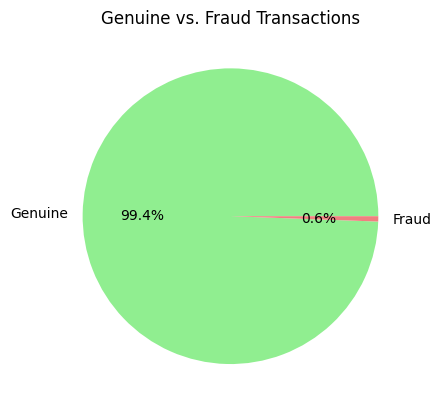

In [3]:
labels = ["Genuine", "Fraud"]

is_fraud_train = data["is_fraud"].value_counts()

plt.pie(is_fraud_train,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions")
plt.show()

Since 99.4% of the data are genuine transactions, if we do a blind guess of genuine transactions, we will have an accuracy of 99.4%.

## Exploratory Data Analysis

Renaming the columns to be more intuitive and converted the times to be datetimes.

In [4]:
data.rename(columns={"cc_num": "credit_card",
                     "trans_date_trans_time": "trans_time",
                     "trans_num": "trans_id"},
                inplace=True)

# Turning the transaction time to be numerical and based on time only.
data["trans_time"] = pd.to_datetime(data["trans_time"])
data["dob"] = pd.to_datetime(data["dob"])

# Changing to time of day.
data["time"] = pd.to_datetime(data["unix_time"], unit="s")
data["time"] = data["time"].dt.hour

data.head(5)

,trans_time,credit_card,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud,time
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0


Checking for missing data.

In [5]:
data.isnull().sum()

trans_time     0
credit_card    0
merchant       0
category       0
amt            0
first          0
last           0
gender         0
street         0
city           0
state          0
zip            0
lat            0
long           0
city_pop       0
job            0
dob            0
trans_id       0
unix_time      0
merch_lat      0
merch_long     0
is_fraud       0
time           0
dtype: int64

Checking elements within features.

In [6]:
for col in data:
    unique_vals = np.unique(data[col])
    n_unique = len(unique_vals)
    if n_unique < 24:
        print(f"The number of unique values for features {col}: {n_unique} ---> {unique_vals}")
    else:
        print(f"The number of unique values for features {col}: {n_unique}")

The number of unique values for features trans_time: 1274791
The number of unique values for features credit_card: 983
The number of unique values for features merchant: 693
The number of unique values for features category: 14 ---> ['entertainment' 'food_dining' 'gas_transport' 'grocery_net' 'grocery_pos'
 'health_fitness' 'home' 'kids_pets' 'misc_net' 'misc_pos' 'personal_care'
 'shopping_net' 'shopping_pos' 'travel']
The number of unique values for features amt: 52928
The number of unique values for features first: 352
The number of unique values for features last: 481
The number of unique values for features gender: 2 ---> ['F' 'M']
The number of unique values for features street: 983
The number of unique values for features city: 894
The number of unique values for features state: 51
The number of unique values for features zip: 970
The number of unique values for features lat: 968
The number of unique values for features long: 969
The number of unique values for features city_pop

Visualizing transaction amounts over time.

In [7]:
grouped = data.groupby(by=[pd.Grouper(key="trans_time", freq="1M"), 'category'])
grouped = grouped.aggregate({"amt":'sum',"trans_id":"count"}).reset_index()

fig = px.area(grouped, x='trans_time', y='amt', 
              color='category', title="Transaction Amounts Over Time",
              labels={'trans_time': 'Transaction Time', 'amt': 'Amount'})

fig.update_layout(height=600, width=900, legend=dict(title='Categories'))

fig.show()

Visualizing transactions by category.

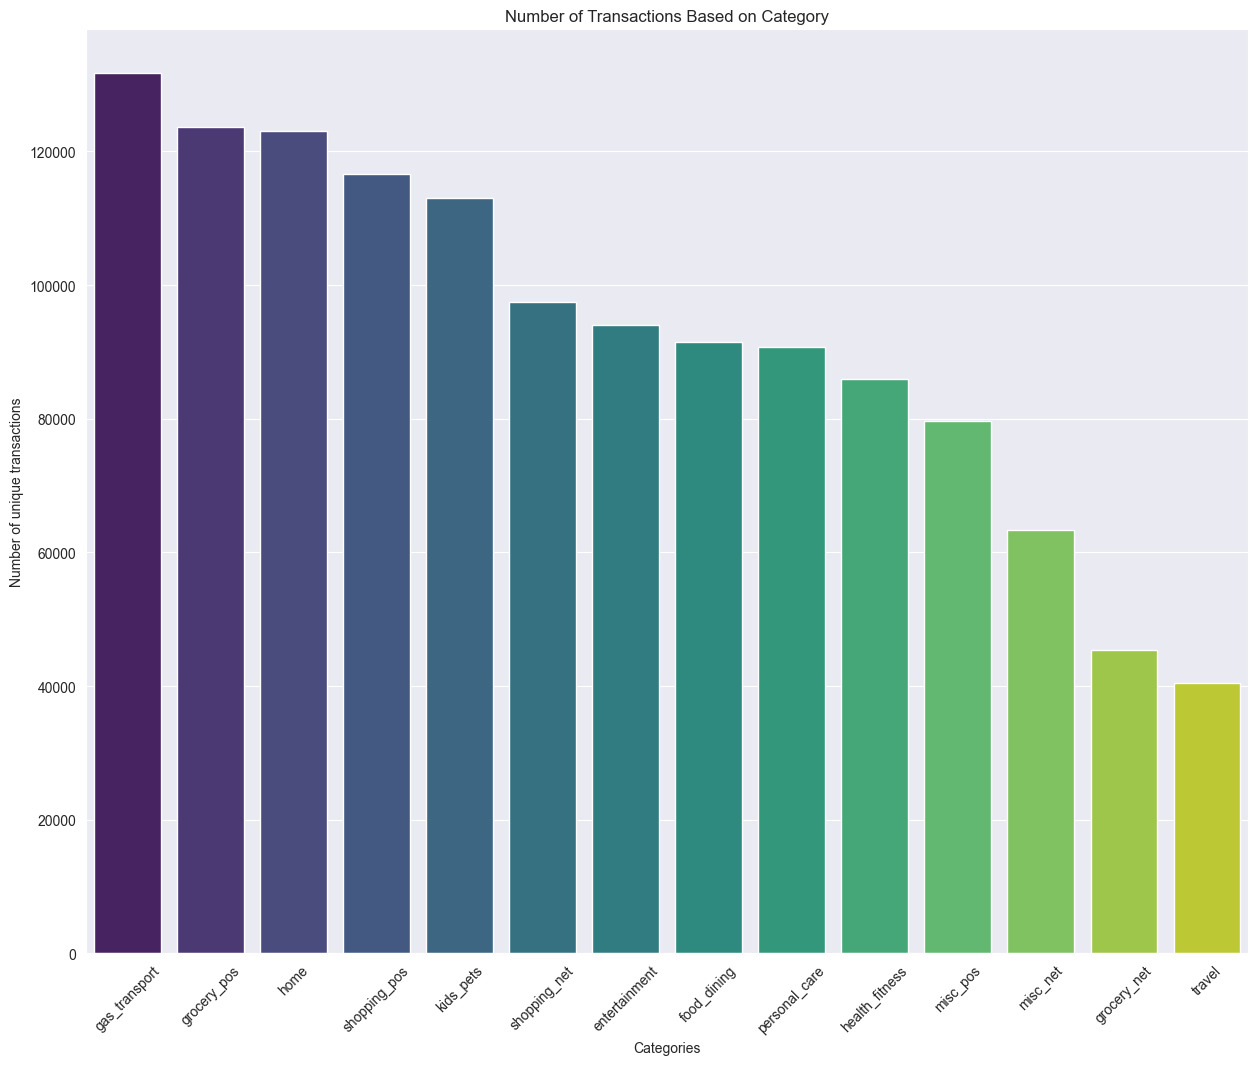

<Figure size 1500x1200 with 0 Axes>

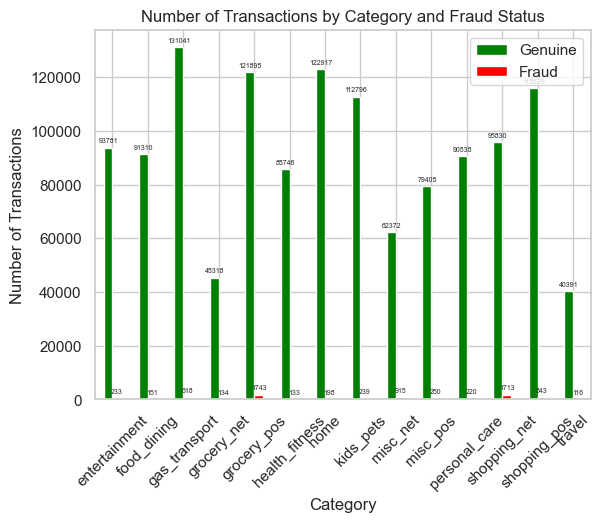

In [8]:
grouped = data.groupby("trans_id")["category"].aggregate("max").reset_index()
grouped = grouped.category.value_counts()

# Plotting
sns.set_style('dark')
colors = sns.color_palette("viridis", n_colors=len(grouped))
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(x=grouped.index, y=grouped.values, hue=grouped.index, ax=ax, palette=colors, legend=False)
ax.grid(True, axis='y')

plt.xticks(rotation=45)
plt.ylabel('Number of unique transactions')
plt.xlabel('Categories')
plt.title('Number of Transactions Based on Category')
plt.show()

# Split into fraud or not
grouped = data[["trans_id", "category", "is_fraud"]].groupby(['category', 'is_fraud']).size().unstack()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))
ax = grouped.plot(kind='bar', stacked=False, color=['green', 'red'])

# Adding the numbers to bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=5)

plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Category and Fraud Status')
plt.legend(['Genuine', 'Fraud'])
plt.show()

Visualizing transactions based on time of day.

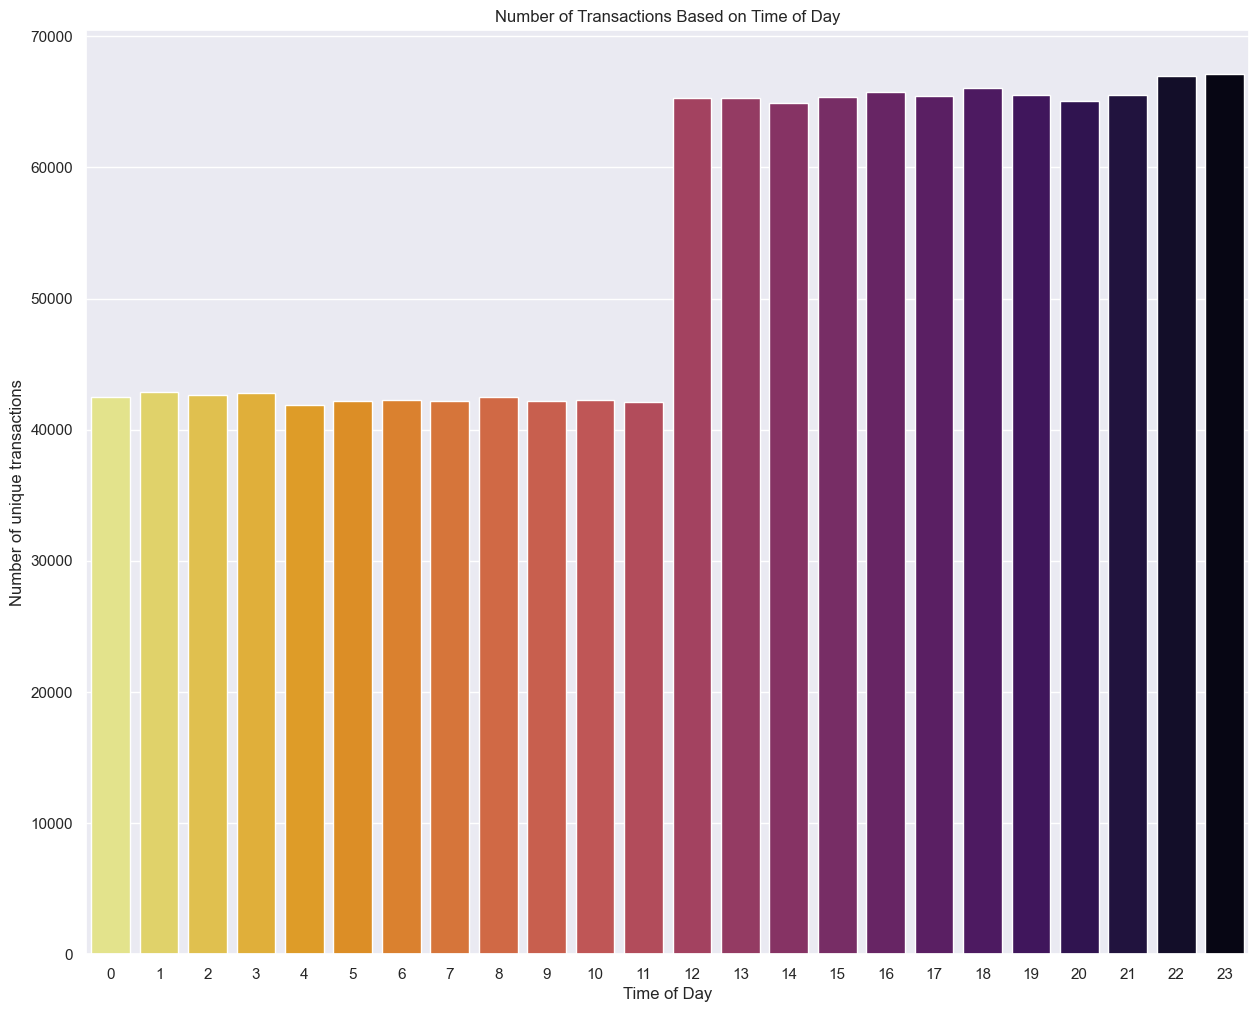

<Figure size 1500x1200 with 0 Axes>

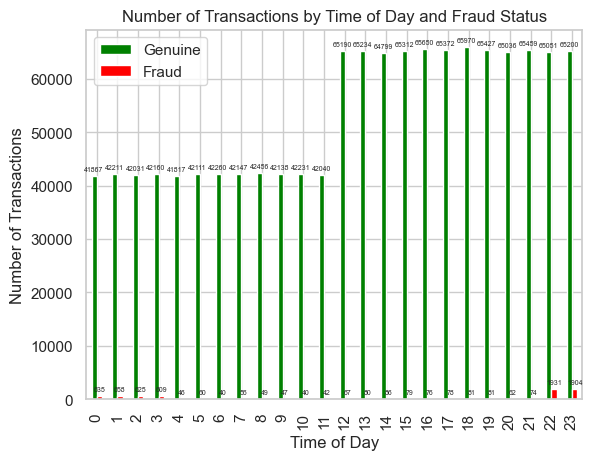

In [9]:
grouped = data.groupby("trans_id")["time"].aggregate("max").reset_index()
grouped = grouped.time.value_counts()

# Plotting
sns.set_style('dark')
colors = sns.color_palette("inferno_r", n_colors=len(grouped))
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(x=grouped.index, y=grouped.values, hue=grouped.index, ax=ax, palette=colors, legend=False)
ax.grid(True, axis='y')

plt.ylabel('Number of unique transactions')
plt.xlabel('Time of Day')
plt.title('Number of Transactions Based on Time of Day')
plt.show()

# Split into fraud or not
grouped = data[["trans_id", "time", "is_fraud"]].groupby(['time', 'is_fraud']).size().unstack()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))
ax = grouped.plot(kind='bar', stacked=False, color=['green', 'red'])

# Adding the numbers to bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=5)

plt.xlabel('Time of Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Time of Day and Fraud Status')
plt.legend(['Genuine', 'Fraud'])
plt.show()

## Preprocessing Data
We convert the date of birth to age and normalize the amount.

In [10]:
# Normalizing the amount via log(1 + amt)
data["amt"] = np.log1p(data["amt"])

# Change dob to age to prevent data leakage, and removal of private information
data["age"] = data["trans_time"].dt.year - data["dob"].dt.year


Removing any unecessary features and taking the 4 most recent months as testing data to prevent data leakage.

In [12]:
# Removed trans_id. Replaced unix_time and trans_date_trans_time with time. Replaced dob with age.
# Also removed private information such as name, dob, address.
features = ['credit_card', 'merchant', 'category', 'amt', 'gender', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'age', 'merch_lat', 'merch_long', 'time']
categorical_features = ['credit_card', 'merchant', 'category', 'gender', 'state', 'zip', 'job', 'age']
target = "is_fraud"

# Separates all the data within the most recent MONTH_DIFF months to prevent data leakage
MONTH_DIFF = 4 # Sets the month difference to split by for training
MONTH_DIFF_TEST = MONTH_DIFF/2 # Sets the month difference to split by for validation
most_recent_transaction = data["trans_time"].max()
data["month_difference"] = abs(data["trans_time"] - most_recent_transaction) / np.timedelta64(30, "D")

data_train = data[data["month_difference"] > MONTH_DIFF]
data_val = data[(data["month_difference"] <= MONTH_DIFF) 
                & (data["month_difference"] > MONTH_DIFF_TEST)]
data_test = data[data["month_difference"]  <= MONTH_DIFF_TEST]

Splitting our data into training and testing and encoding the data

In [13]:
# Split the data into train, test and validation
X_train = data_train[features]
Y_train = data_train[target]

X_val = data_val[features]
Y_val = data_val[target]

X_test = data_test[features]
Y_test = data_test[target]

# Using ordinal encodings to encode categorical features for data.
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.float64)

X_train.loc[:, categorical_features] = ord_enc.fit_transform(X_train[categorical_features])
X_val.loc[:, categorical_features] = ord_enc.transform(X_val[categorical_features])
X_test.loc[:, categorical_features] = ord_enc.transform(X_test[categorical_features])

X_train = X_train.astype("float64")
X_val = X_val.astype("float64")
X_test = X_test.astype("float64")

## Feature Importance

To determine which features to select, fit a model to the data.

In [14]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=1)

Using feature permutation, plot the feature importance to determine the most important features.

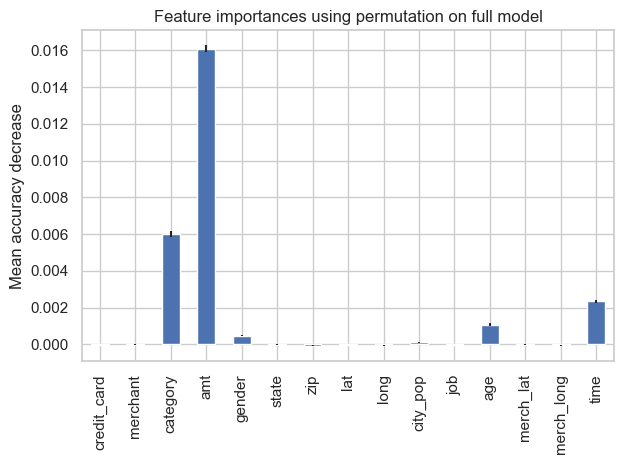

In [15]:
perm_res = permutation_importance(
    model_rf, X_val, Y_val, n_repeats=10, random_state=RANDOM_STATE, n_jobs=4
)

perm_importances = pd.Series(perm_res.importances_mean, index=features)

perm_fig, perm_ax = plt.subplots()
perm_importances.plot.bar(yerr=perm_res.importances_std, ax=perm_ax)
perm_ax.set_title("Feature importances using permutation on full model")
perm_ax.set_ylabel("Mean accuracy decrease")
perm_fig.tight_layout()
plt.show()

The features `["category", "amt", "gender", "city_pop", "age", "time"]` were found to be the most important.

In [16]:
selected_features = ["category", "amt", "gender", "city_pop", "age", "time"]

X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]

## Baseline Performance
We take a look at the baseline performance of Random Forest

In [18]:
model_rf.fit(X_train, Y_train)

Y_pred_model_rf = model_rf.predict(X_val)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131770
           1       0.95      0.82      0.88       745

    accuracy                           1.00    132515
   macro avg       0.97      0.91      0.94    132515
weighted avg       1.00      1.00      1.00    132515



Metrics train:
	Accuracy score: 1.0000
Metrics test:
	Accuracy score: 0.9987


Confusion Matrix:


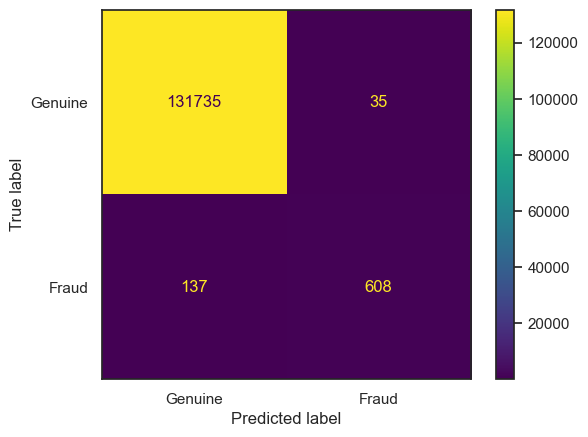

In [21]:
print(f"Classification Report: \n{classification_report(Y_val, Y_pred_model_rf)}\n\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_model = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_model_rf), display_labels=["Genuine", "Fraud"])
cm_display_model.plot()

## SMOTE + Tomek Links
Because the data is imbalanced, we combine SMOTE and Tomek Links to resample the data.

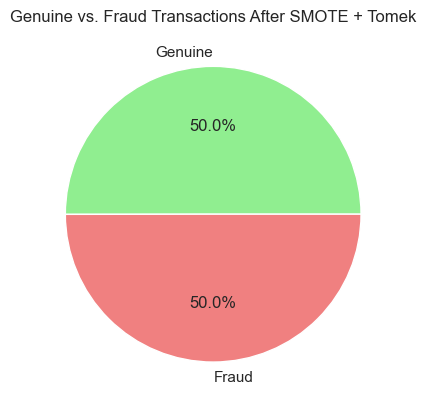

In [22]:
tomek = TomekLinks(sampling_strategy="majority")
smotetomek = SMOTETomek(tomek=tomek, random_state=RANDOM_STATE)

X_train_smotetomek, Y_train_smotetomek = smotetomek.fit_resample(X_train, Y_train)

# Plot the data after resampling
is_fraud_train_smotetomek = Y_train_smotetomek.value_counts()

plt.pie(is_fraud_train_smotetomek,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions After SMOTE + Tomek")
plt.show()

Running the line of code below will cause the rest of the notebook to use the SMOTE + Tomek data.

In [23]:
X_train, Y_train = X_train_smotetomek, Y_train_smotetomek

## Model: AdaBoost
AdaBoost adds weights to each stump, making it a more accurate classifier compared to RandomForest.

Finding and tuning hyperparameters of the AdaBoost using RandomizedSearch.

In [25]:
n_estimators = [50, 100, 150, 200] # Determines the number of trees used per forest
learning_rate = [0.01, 0.1, 0.3, 0.5, 1, 1.5]
param_grid_ada = {"n_estimators": n_estimators,
                 "learning_rate": learning_rate}

grid_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=RANDOM_STATE), 
                                  param_grid_ada, 
                                  verbose=3, n_jobs=4,
                                  n_iter=10, random_state=RANDOM_STATE)
grid_ada.fit(X_train, Y_train)

print(f"AdaBoost Params: {grid_ada.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.923 total time= 1.4min
[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.922 total time= 1.4min
[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.921 total time= 1.4min
[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.922 total time= 1.4min
[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.922 total time= 1.4min
[CV 1/5] END .learning_rate=1, n_estimators=150;, score=0.953 total time= 2.1min
[CV 2/5] END .learning_rate=1, n_estimators=150;, score=0.955 total time= 2.1min
[CV 3/5] END .learning_rate=1, n_estimators=150;, score=0.952 total time= 2.2min
[CV 4/5] END .learning_rate=1, n_estimators=150;, score=0.952 total time= 2.1min
[CV 5/5] END .learning_rate=1, n_estimators=150;, score=0.951 total time= 2.1min
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=0.836 total time= 2.8min
[CV 2/5] END learning_rate=0.01, n_estima

```{note}
This will take a while (~30 minutes), so not running RandomizedSearch and using the default values given should work.
With the default hyperparameters, it should take 2-4 minutes.
```

Fitting the data to the Random Forest with the hyperparameters found.

In [27]:
try:
    n_estimators_ada = grid_ada.best_params_["n_estimators"]
    learning_rate_ada = grid_ada.best_params_["learning_rate"]
except (NameError, AttributeError):
    n_estimators_ada = 200
    learning_rate_ada = 1

model_ada = AdaBoostClassifier(
                            learning_rate=learning_rate_ada,
                            n_estimators=n_estimators_ada,
                            random_state=RANDOM_STATE)
model_ada.fit(X_train, Y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=1)

Analysis using a classification report, confusion matrix and accuracy.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    131770
           1       0.17      0.80      0.28       745

    accuracy                           0.98    132515
   macro avg       0.58      0.89      0.63    132515
weighted avg       0.99      0.98      0.98    132515


Metrics train:
	Accuracy score: 0.9590
Metrics test:
	Accuracy score: 0.9771


Confusion Matrix:


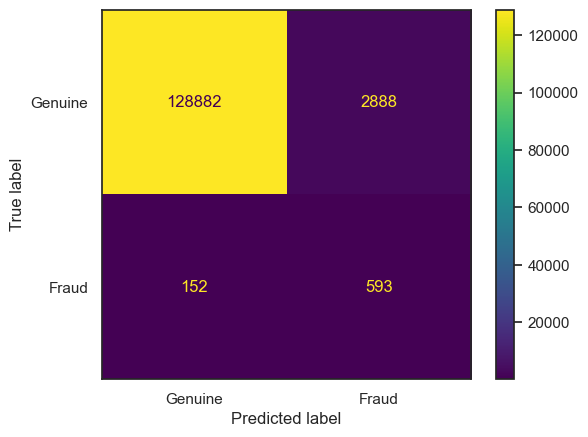

In [28]:
Y_pred_ada = model_ada.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_ada)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_ada.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_ada.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_ada = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_ada), display_labels=["Genuine", "Fraud"])
cm_display_ada.plot()

### Model: XGBoostClassifier
In order to speedup the algorithm, we use XGBoost.

Finding and tuning hyperparameters of the XGBClassifier using RandomizedSearch.

In [29]:
max_depths = [3, 5, 7, 10] # Determines how far down a decision tree goes before stopping
gamma = [0.1, 0.3, 0.5, 0.9] # Determines minimum loss reduction for a split
min_child_weight = [1, 3, 5, 7] #  Determines minimum weight needed for a child
learning_rate = [0.1, 0.3, 0.5, 0.7, 1]
param_grid_xgb = {"max_depth": max_depths,
                  "gamma": gamma,
                  "min_child_weight": min_child_weight,
                  "learning_rate": learning_rate}

grid_xgb = RandomizedSearchCV(XGBClassifier(random_state=RANDOM_STATE), 
                                  param_grid_xgb, 
                                  verbose=3, n_jobs=4,
                                  n_iter=15, random_state=RANDOM_STATE)
grid_xgb.fit(X_train, Y_train)

print(f"Random Forest Params: {grid_xgb.best_params_}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 3/5] END gamma=0.3, learning_rate=0.5, max_depth=7, min_child_weight=7;, score=0.998 total time=   5.4s
[CV 1/5] END gamma=0.3, learning_rate=0.5, max_depth=7, min_child_weight=7;, score=0.997 total time=   5.4s
[CV 2/5] END gamma=0.3, learning_rate=0.5, max_depth=7, min_child_weight=7;, score=0.998 total time=   5.4s
[CV 4/5] END gamma=0.3, learning_rate=0.5, max_depth=7, min_child_weight=7;, score=0.998 total time=   5.4s
[CV 5/5] END gamma=0.3, learning_rate=0.5, max_depth=7, min_child_weight=7;, score=0.998 total time=   5.2s
[CV 1/5] END gamma=0.3, learning_rate=0.3, max_depth=10, min_child_weight=5;, score=0.997 total time=   6.7s
[CV 2/5] END gamma=0.3, learning_rate=0.3, max_depth=10, min_child_weight=5;, score=0.998 total time=   6.8s
[CV 3/5] END gamma=0.3, learning_rate=0.3, max_depth=10, min_child_weight=5;, score=0.998 total time=   6.8s
[CV 1/5] END gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV 2/5] END gamma=0.9, learning_rate=0.1, max_depth=3, min_child_weight=5;, score=0.959 total time=   3.1s
[CV 3/5] END gamma=0.9, learning_rate=0.1, max_depth=3, min_child_weight=5;, score=0.957 total time=   3.1s
[CV 4/5] END gamma=0.9, learning_rate=0.1, max_depth=3, min_child_weight=5;, score=0.960 total time=   3.0s
[CV 5/5] END gamma=0.9, learning_rate=0.1, max_depth=3, min_child_weight=5;, score=0.959 total time=   2.8s
[CV 1/5] END gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.986 total time=   3.7s
[CV 2/5] END gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.988 total time=   4.1s
[CV 4/5] END gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.988 total time=   3.8s
[CV 3/5] END gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.988 total time=   3.8s
[CV 5/5] END gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.989 total time=   3.6s
[CV 2/5] END gamma=0.9, lear

```{note}
This may take a while, so not running RandomizedSearch and using the default values given should work.
```

Fitting the data to the XGBClassifier with the hyperparameters found.

In [30]:
try:
    max_depth_xgb = grid_xgb.best_params_["max_depth"]
    gamma_xgb = grid_xgb.best_params_["gamma"]
    min_child_weight_xgb = grid_xgb.best_params_["min_child_weight"]
    learning_rate_xgb = grid_xgb.best_params_["learning_rate"]
except (NameError, AttributeError):
    max_depth_xgb = 7
    gamma_xgb = 0.1
    min_child_weight_xgb = 5
    learning_rate_xgb = 0.3

model_xgb = XGBClassifier(
                            max_depth=max_depth_xgb,
                            gamma=gamma_xgb,
                            min_child_weight=min_child_weight_xgb,
                            learning_rate =learning_rate_xgb,
                            random_state=RANDOM_STATE)

model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131770
           1       0.78      0.84      0.81       745

    accuracy                           1.00    132515
   macro avg       0.89      0.92      0.91    132515
weighted avg       1.00      1.00      1.00    132515


Metrics train:
	Accuracy score: 0.9987
Metrics test:
	Accuracy score: 0.9978


Confusion Matrix:


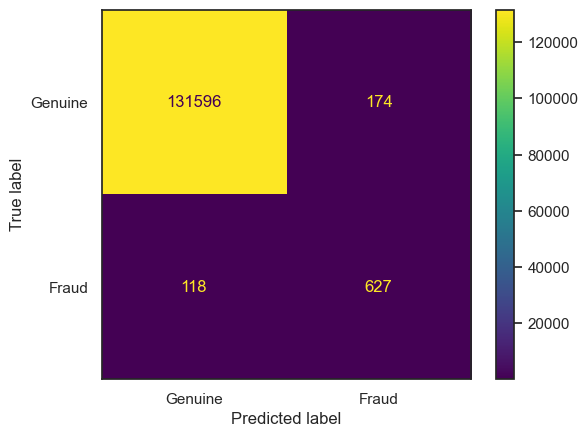

In [31]:
Y_pred_xgb = model_xgb.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_xgb)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_xgb), display_labels=["Genuine", "Fraud"])
cm_display_xgb.plot()

## Cross Validation

We perform cross validation by comparing `f1` scores across the three models we trained.

In [32]:
models = {"AdaBoost": model_ada,
          "XGBoost": model_xgb}

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

best_model = None
best_f1 = None
for name, model in models.items():
    cross_val_res = cross_val_score(model, X_train, Y_train, cv=strat_kf, scoring="f1")

    val_f1 = f1_score(Y_val, model.predict(X_val))

    print(f"{name}: Mean F1 Training = {cross_val_res.mean():.4f}")
    print(f"{name}: F1 Validation = {val_f1:.4f}")

    if best_f1 is None or best_f1 < val_f1:
        best_model = model
        best_f1 = val_f1

AdaBoost: Mean F1 Training = 0.9578
AdaBoost: F1 Validation = 0.2806
XGBoost: Mean F1 Training = 0.9981
XGBoost: F1 Validation = 0.8111


```{note}
This may take a while, so not running the cross validation and using the default best model given below should work.
```

We found the best model to be the XGBoosted trees because it has the highest `f1` score.

## Testing

Finally, we perform a final test on the best model.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149533
           1       0.81      0.85      0.83       948

    accuracy                           1.00    150481
   macro avg       0.90      0.93      0.91    150481
weighted avg       1.00      1.00      1.00    150481


Metrics test:
	Accuracy score: 0.9978


Confusion Matrix:


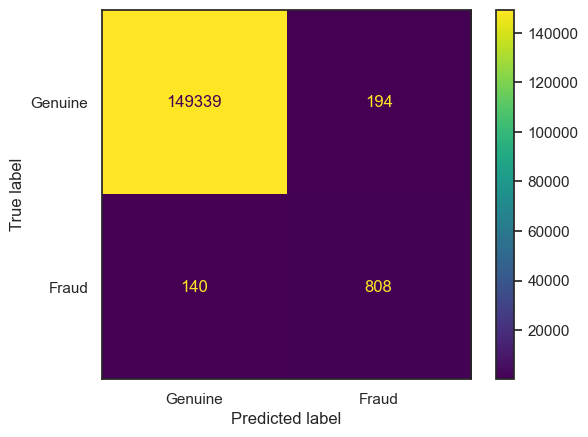

In [33]:
try:
    Y_pred_best = best_model.predict(X_test)
except NameError:
    Y_pred_best = model_xgb.predict(X_test)

print(f"Classification Report: \n{classification_report(Y_test, Y_pred_best)}\n")

print(
    f"Metrics test:\n\tAccuracy score: {accuracy_score(best_model.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_best = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_best), display_labels=["Genuine", "Fraud"])
cm_display_best.plot()

## Feature Importance: XGBoost and SHAP

We plot the feature importance using XGBoost's built-in feature importance to calculate the relative importances.

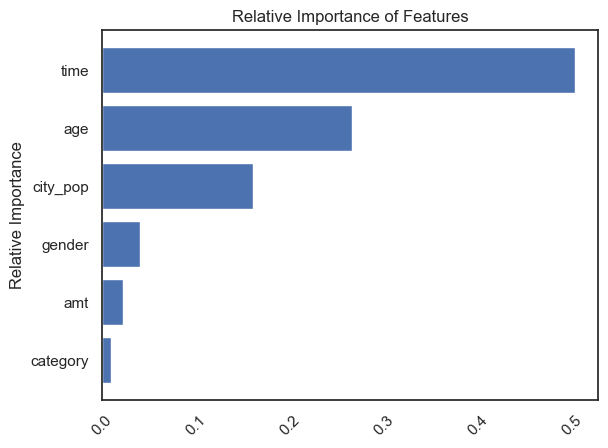

In [34]:
importance_scores = model_xgb.feature_importances_
relative_importance = importance_scores / importance_scores.sum()
relative_importance.sort()

# Plotting
plt.barh(X_train.columns, relative_importance)
plt.xticks(rotation=45)
plt.ylabel('Relative Importance')
plt.title('Relative Importance of Features')
plt.show()

We then compare it to the SHAP values.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[11:16:40] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[11:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



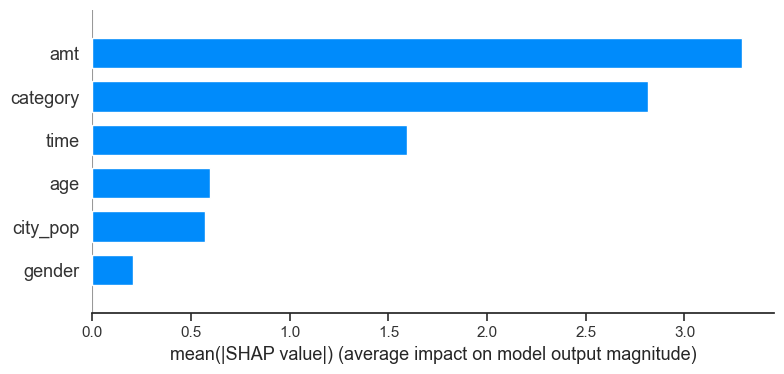

In [45]:
# Explain the model's predictions using SHAP values
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type='bar')
plt.show()

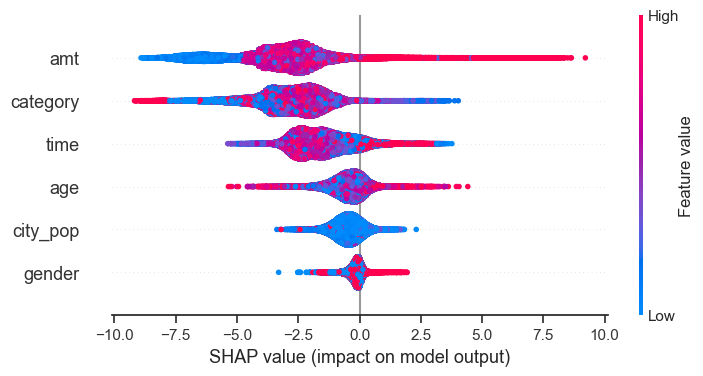

In [46]:
shap.plots.beeswarm(shap_values)

## Summary

Since we are doing fraud detection, we would want to prioritize precision because marking non-fraudulent transactions as frauds can have large  legal repercussions, and even lead to criminal offenses and large fines.

The baseline performance had a very high accuracy score on the training set, which could show signs of overfitting.

Overall, XGBoost had a better accuracy, precision, recall and f1 score compared to AdaBoost. It also had much better performance in speed compared to both Random Forest and AdaBoost, thus making it the best choice in classifying fraudulent transactions.